<a href="https://colab.research.google.com/github/am-tropin/georgian-letters-trainer/blob/main/Georgian_letters_recognition_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Downloading the dataset**

In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/alexandertropin/georgian-letters-photo-database", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexandertropin
Your Kaggle Key: ··········


100%|██████████| 208M/208M [00:02<00:00, 75.8MB/s]


In [ ]:
# remove all .txt files

# import os
# import glob

# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/yolo/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/for_prediction/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/*') # .txt

# for filePath in fileList:
#     os.remove(filePath)

# **2. Cutting images into letters**

In [4]:
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

import glob
import os

import re
from collections import Counter

# import sys, random
# from shutil import copyfile

In [5]:
# https://github.com/Shenggan/BCCD_Dataset/blob/master/export.py


def to_extract_coordinates(source_folder, target_name):
    annotations = glob.glob(source_folder + '*.xml')

    df = []
    cnt = 0

    for file in annotations:
        filename = file.split('/')[-1].split('.')[0] + '.jpg'
        row = []
        parsedXML = ET.parse(file)
        for node in parsedXML.getroot().iter('object'):
            letters = node.find('name').text
            xmin = int(node.find('bndbox/xmin').text)
            xmax = int(node.find('bndbox/xmax').text)
            ymin = int(node.find('bndbox/ymin').text)
            ymax = int(node.find('bndbox/ymax').text)

            row = [filename, letters, xmin, xmax, ymin, ymax]
            df.append(row)
            cnt += 1

    data = pd.DataFrame(df, columns=['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax'])

    data[['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv(target_name + '.csv', index=False)
    return 1

In [6]:
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/dataset/'
target_name = 'label_coordinates'

to_extract_coordinates(source_folder, target_name)

1

In [7]:
df = pd.read_csv('label_coordinates.csv')
df.head()

,filename,letter_name,xmin,xmax,ymin,ymax
0,IMG_20230409_130847.jpg,0ა,1346,1516,1249,1523
1,IMG_20230409_130847.jpg,0ა,1444,1524,2369,2493
2,IMG_20230409_130847.jpg,0ა,1313,1389,2371,2493
3,IMG_20230409_130847.jpg,0ა,1533,1620,2596,2709
4,IMG_20230409_130847.jpg,0ა,2174,2248,2582,2711


In [8]:
df.shape

(4020, 6)

In [9]:
def invert_image(img_test):
    height, width = img_test.shape[:2]
    border_delta = 0.02

    # mean grayscale value
    mean_image = np.mean(img_test)

    # grayscale values near the borders
    mean_left_border = np.mean(img_test[:, int(width*(1-border_delta)):width])
    mean_right_border = np.mean(img_test[:, 0:int(width*border_delta)])
    mean_upper_border = np.mean(img_test[0:int(height*border_delta), :])
    mean_lower_border = np.mean(img_test[int(height*(1-border_delta)):height, :])

    if mean_image > np.mean(np.array([mean_left_border, mean_right_border, mean_upper_border, mean_lower_border])):
        return cv2.bitwise_not(img_test)
    else:
        return img_test


In [10]:
def to_crop_letters(df, source_folder, target_folder, width, height):
    '''
    This function is for processing the letters.
    '''
    letter_names = set(list(df['letter_name']))

    # a counter of letters within each image
    letter_counter = {}

    for index, row in df.iterrows():
        if row['filename'] in letter_counter.keys():
            if row['letter_name'] in letter_counter[row['filename']].keys():
                letter_counter[row['filename']][row['letter_name']] += 1
            else:
                letter_counter[row['filename']][row['letter_name']] = 1
        else:
            letter_counter[row['filename']] = {}
            letter_counter[row['filename']][row['letter_name']] = 1

        img = cv2.imread(source_folder + row['filename'])
        crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
        try:
            crop_resize_img = cv2.resize(crop_img, (width, height))
            gray_crop_resize_img = cv2.cvtColor(crop_resize_img, cv2.COLOR_BGR2GRAY)
            invert_img = invert_image(gray_crop_resize_img)
            # thresh_img = invert_img
            thresh_img = cv2.threshold(invert_img, np.mean(invert_img), 255, cv2.THRESH_BINARY)[1]
        except:
            thresh_img = crop_img
            print(row)
        # thresh_img = cv2.threshold(invert_img, (np.amin(invert_img) + np.amax(invert_img))//2, 255, cv2.THRESH_BINARY)[1]
        # 127, 255
        # cv2.THRESH_BINARY: If pixel intensity is greater than the set threshold, value set to 255, else set to 0 (black).
        cv2.imwrite(target_folder + row['filename'][:-4] + '_' + row['letter_name'][-1] + '_' + str(letter_counter[row['filename']][row['letter_name']]) + '.jpg', thresh_img)
    return 1

In [11]:
!mkdir cropped_images

mkdir: cannot create directory ‘cropped_images’: File exists


In [12]:
'''
Creating a new dataset of images with singular letters.
Grayscale. 
Resized to 100x150.
Inverted (black <-> white) if the borders are darker than the image on the average
'''


'''
OLD:
4.5 minutes for processing of a full dataset (86 images / 1302 letters)
'''

'''
NEW:
19 minutes for processing of a full dataset (46 images / 4020 letters)
'''

df_short = df #.head(100)

# the folder where images locate
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/dataset/'

# the folder where cropped images will be saved
target_folder = 'cropped_images/'

my_height, my_width = 32, 32
# 96, 64
# 100, 150

to_crop_letters(df_short, source_folder, target_folder, my_width, my_height) 

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1

In [ ]:
# files = glob.glob('cropped_images/*')
# for f in files:
#     os.remove(f)

In [ ]:
# !rmdir croped_images

Downloading the cropped images:

In [13]:
!zip -r /content/cropped_images.zip /content/cropped_images

from google.colab import files
files.download("/content/cropped_images.zip")

updating: content/cropped_images/ (stored 0%)
updating: content/cropped_images/IMG_20230306_173755_ბ_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_ი_16.jpg (deflated 0%)
updating: content/cropped_images/IMG_20230315_003205_ღ_1.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_134823 (1)_ს_4.jpg (stored 0%)
updating: content/cropped_images/IMG_20230213_174613_ე_4.jpg (stored 0%)
updating: content/cropped_images/IMG_20230312_233457_რ_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_პ_7.jpg (stored 0%)
updating: content/cropped_images/IMG_20230216_185740 (1)_ქ_1.jpg (stored 0%)
updating: content/cropped_images/IMG_20230424_114451_ა_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_135956 (1)_ს_8.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_ნ_21.jpg (stored 0%)
updating: content/cropped_images/IMG_20230123_122233_ა_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230302_132126_ც_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# I need to invert colors for some pictures:

custom_invert_images = [
    'IMG_20230213_212448_ო_5',
    'IMG_20230215_135956 (1)_ა_10',
    'IMG_20230215_135956 (1)_ა_19',
    'IMG_20230215_135956 (1)_ა_28',
    'IMG_20230215_135956 (1)_ე_3',
    'IMG_20230215_135956 (1)_ო_7',
    'IMG_20230215_135956 (1)_ო_8',
    'IMG_20230215_135956 (1)_წ_4'
]

for im in custom_invert_images:
    file_path = '/content/cropped_images/' + im + '.jpg'
    img = cv2.imread(file_path)
    # print(file_path)
    # cv2_imshow(img)
    cv2.imwrite(file_path, cv2.bitwise_not(img))

    # os.remove('content/cropped_images/' + im + '.jpg')
  # content/cropped_images/IMG_20230425_142943-2_ნ_17.jpg
    
# target_folder = 'cropped_images/'

In [15]:
# I need to remove some pictures with dual background:

# IMG_20230215_135136 (1) - a lof of

dir_list = os.listdir("cropped_images/")

for d in dir_list:
    if 'IMG_20230215_135136 (1)' in d:
        os.remove('/content/cropped_images/' + d)

In [16]:
# I need to extract some images for predicting dataset

import shutil

!mkdir cropped_images_predict

dir_list = os.listdir("cropped_images/")
for d in dir_list:
    if 'IMG_20230315_001116' in d:
        shutil.move('/content/cropped_images/' + d, '/content/cropped_images_predict/' + d)


mkdir: cannot create directory ‘cropped_images_predict’: File exists


In [17]:
dir_list = os.listdir("cropped_images/")

# ა_list = [d for d in dir_list if "ა" in d]
letter_list = [re.findall("\_(.)\_", d)[0] for d in dir_list if re.findall("\_(.)\_", d)]


# to detect the most frequent letters
letter_counter = Counter(letter_list)
letter_counter.most_common()

[('ი', 554),
 ('ა', 530),
 ('ე', 334),
 ('ს', 246),
 ('რ', 244),
 ('ო', 219),
 ('ლ', 193),
 ('ნ', 155),
 ('მ', 138),
 ('დ', 134),
 ('ბ', 130),
 ('უ', 128),
 ('ვ', 116),
 ('თ', 99),
 ('ტ', 96),
 ('გ', 85),
 ('კ', 71),
 ('ქ', 59),
 ('შ', 59),
 ('ფ', 56),
 ('პ', 52),
 ('ხ', 52),
 ('ზ', 47),
 ('ც', 42),
 ('წ', 25),
 ('ღ', 19),
 ('ყ', 15),
 ('ძ', 14),
 ('ჭ', 12),
 ('ჩ', 11),
 ('ჯ', 11),
 ('ჟ', 5),
 ('ჰ', 4)]

# **3. Distributing the top of letters by separate folders**

I will create folders for 7 most frequent letters and another one for the others.

In [34]:
# import shutil

# src_path = r"E:\pynative\reports\sales.txt" # source
# dst_path = r"E:\pynative\account\sales.txt" # destination
# shutil.move(src_path, dst_path) # move
# shutil.copyfile(src_path, dst_path) # copy

In [18]:
treshold = 190

In [19]:
head_letter_dict = {x: count for x, count in Counter(letter_list).items() if count >= treshold}
head_letter_dict = {k: v for k, v in sorted(head_letter_dict.items(), key=lambda item: item[1], reverse=True)}
head_letter_dict

{'ი': 554, 'ა': 530, 'ე': 334, 'ს': 246, 'რ': 244, 'ო': 219, 'ლ': 193}

In [20]:
tail_letter_dict = {x: count for x, count in Counter(letter_list).items() if count < treshold}
tail_letter_dict = {k: v for k, v in sorted(tail_letter_dict.items(), key=lambda item: item[1], reverse=True)}
# tail_letter_dict

In [21]:
head_letter_dict['other'] = np.sum([v for v in tail_letter_dict.values()])
head_letter_dict

{'ი': 554,
 'ა': 530,
 'ე': 334,
 'ს': 246,
 'რ': 244,
 'ო': 219,
 'ლ': 193,
 'other': 1635}

In [ ]:
# for filePath in glob.glob("cropped_images_i/*.jpg"):
#     filePath_splitted = filePath.split('/')
#     shutil.move(filePath, 'cropped_images/' + filePath_splitted[1])

In [22]:
del head_letter_dict['other']

In [24]:
base_dir = 'grouped_images'
os.mkdir(base_dir)

for letter in head_letter_dict.keys():
    os.mkdir(base_dir + '/letter_' + letter)

In [25]:
# distributing images with top of letters by folders
for letter in head_letter_dict.keys():
    fileList = [f for f in glob.glob("cropped_images/*.jpg") if letter in f]
    for filePath in fileList:
        filePath_splitted = filePath.split('/')
        shutil.copyfile(filePath, 'grouped_images/letter_'+letter+'/' + filePath_splitted[1])


In [ ]:
# and the rest:
# fileList = [f for f in glob.glob("cropped_images/*.jpg") if not any(letter in f for letter in head_letter_dict.keys())]
# for filePath in fileList:
#     filePath_splitted = filePath.split('/')
#     shutil.copyfile(filePath, 'grouped_images/letter_other/' + filePath_splitted[1])


# **4. Distributing images by test, validation and train folders for each letter**

based on https://www.analyticsvidhya.com/blog/2022/07/training-cnn-from-scratch-using-the-custom-dataset/

In [26]:
base_dir = 'grouped_images'
dataset_types = ["train", "validation", "test"]

In [27]:
for t in dataset_types:
    t_dir = os.path.join(base_dir, t)
    os.mkdir(t_dir)
    for letter in head_letter_dict.keys():
        t_letter_dir = os.path.join(t_dir, letter)
        os.mkdir(t_letter_dir)


In [28]:
letter_sizes = {}

for letter, amount in head_letter_dict.items():
    letter_sizes[letter] = {}
    letter_sizes[letter]['test'] = int(np.floor(amount * 0.2))
    letter_sizes[letter]['validation'] = int(np.floor((amount - letter_sizes[letter]['test']) * 0.2))
    letter_sizes[letter]['train'] = amount - (letter_sizes[letter]['test'] + letter_sizes[letter]['validation'])
    # print(head_letter_dict[letter])

letter_sizes

{'ი': {'test': 110, 'validation': 88, 'train': 356},
 'ა': {'test': 106, 'validation': 84, 'train': 340},
 'ე': {'test': 66, 'validation': 53, 'train': 215},
 'ს': {'test': 49, 'validation': 39, 'train': 158},
 'რ': {'test': 48, 'validation': 39, 'train': 157},
 'ო': {'test': 43, 'validation': 35, 'train': 141},
 'ლ': {'test': 38, 'validation': 31, 'train': 124}}

In [ ]:
# '''
# TO DELETE OTHER LETTERS
# '''

# files = glob.glob('grouped_images/letter_other/*')
# ბ დ // ვ მ ტ უ ნ
# files = glob.glob('grouped_images/test/დ/*')
# for f in files:
#     os.remove(f)

# !rmdir grouped_images/test/დ

In [ ]:
# extra_letters = ['ბ', 'დ', 'ვ', 'მ', 'ტ', 'უ', 'ნ'] # 
# folder_categories = ['train', 'test', 'validation']

# for ff in folder_categories:
#     for ll in extra_letters:
#         # for f in glob.glob('grouped_images/' + ff + '/' + ll + '/*'):
#         #     os.remove(f)
#         !rmdir os.path.join(os.getcwd(), 'grouped_images', ff, ll)

In [ ]:
# del head_letter_dict['other']

In [29]:
for letter in head_letter_dict.keys():
    file_names = [f.split('/')[-1] for f in os.listdir('grouped_images/letter_' + letter)]

    test_names = file_names[:letter_sizes[letter]['test']]
    validation_names = file_names[letter_sizes[letter]['test']:letter_sizes[letter]['test']+letter_sizes[letter]['validation']]
    train_names = file_names[-letter_sizes[letter]['train']:]

    original_dir = 'grouped_images/letter_' + letter

    for f in test_names:
        target_dir = 'grouped_images/test/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)

    for f in validation_names:
        target_dir = 'grouped_images/validation/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)

    for f in train_names:
        target_dir = 'grouped_images/train/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)


# **5. Training the CNN**

based on https://www.analyticsvidhya.com/blog/2022/07/training-cnn-from-scratch-using-the-custom-dataset/

about handwritten letters: https://data-flair.training/blogs/handwritten-character-recognition-neural-network/

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam


In [ ]:
# ??????

# import tensorflow as tf
# import tensorflow_datasets as tfds

# # tf.enable_eager_execution()

# from keras.layers.core import Dense, Activation, Dropout, Flatten
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
# from keras.optimizers import SGD, RMSprop, Adam
# from keras.utils import np_utils
# from keras.models import Sequential

# from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# from sklearn import metrics
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import random
# # from numpy import *
# from PIL import Image
# import theano

In [31]:
# based on: https://medium.com/artificialis/get-started-with-computer-vision-by-building-a-digit-recognition-model-with-tensorflow-b2216823b90a

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(my_height, my_width, 1)))
model.add(Conv2D(16, (3, 3), activation='relu')) # , padding='same'
# model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(16, (3, 3), activation='relu', padding='valid'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax')) # sigmoid # 1
# == num_classes 9 8 ?
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                    

In [ ]:
# '''
# OLD VERSION
# '''

# ###-----Build Your Model------###
# # from keras import layers
# # from keras import models

# # from keras.models import Sequential
# # from keras.layers.core import Dense, Activation, Dropout, Flatten
# # from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D

# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
# from keras.optimizers import SGD, Adam

# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 100, 1)))
# # model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

# # model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# # model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# # model.add(MaxPool2D((2, 2), strides=2))
# # model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# # model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))
# # model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

# # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# # model.add(MaxPool2D((2, 2), strides=(2,2)))
# # model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))

# model.add(Dense(1, activation='softmax')) # sigmoid # 1
# # == num_classes
# # 9 ?
# model.summary()


In [32]:
####----Configuring the model for training-----####
from tensorflow import keras
from keras import optimizers

model.compile(loss='categorical_crossentropy', # binary_crossentropy 
              # sparse_categorical_crossentropy - 9 classes
              # categorical_crossentropy - 8 classes
              optimizer=keras.optimizers.Adam(), 
              # optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])


In [33]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [34]:
#####-----Data Preprocessing-----######

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# about .flow_from_directory: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(my_height, my_width), batch_size=5, class_mode='categorical', color_mode = 'grayscale') # was: 'binary'
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(my_height, my_width), batch_size=5, class_mode='categorical', color_mode = 'grayscale') # was: batch_size=20

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 1491 images belonging to 7 classes.
Found 369 images belonging to 7 classes.
data batch shape: (5, 32, 32, 1)
labels batch shape: (5, 7)


In [35]:
####----Fit the Model----####
history = model.fit(train_generator, epochs=4, validation_data=validation_generator)
# 10 4 
# steps_per_epoch=5, 
# , validation_steps=50
# about parameters: https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

######-----Save the Model-------######
model.save('geo_letters_top8.h5')

Epoch 1/4
299/299 [==============================] - 9s 23ms/step - loss: 0.8775 - accuracy: 0.6888 - val_loss: 0.1715 - val_accuracy: 0.9593
Epoch 2/4
299/299 [==============================] - 5s 18ms/step - loss: 0.1212 - accuracy: 0.9718 - val_loss: 0.1671 - val_accuracy: 0.9566
Epoch 3/4
299/299 [==============================] - 5s 16ms/step - loss: 0.0499 - accuracy: 0.9873 - val_loss: 0.1504 - val_accuracy: 0.9648
Epoch 4/4
299/299 [==============================] - 6s 20ms/step - loss: 0.0416 - accuracy: 0.9886 - val_loss: 0.1192 - val_accuracy: 0.9756


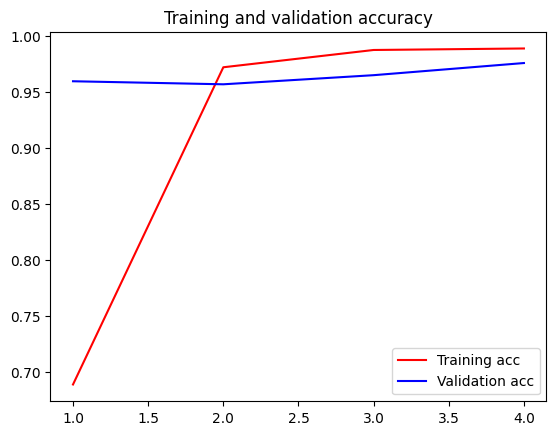

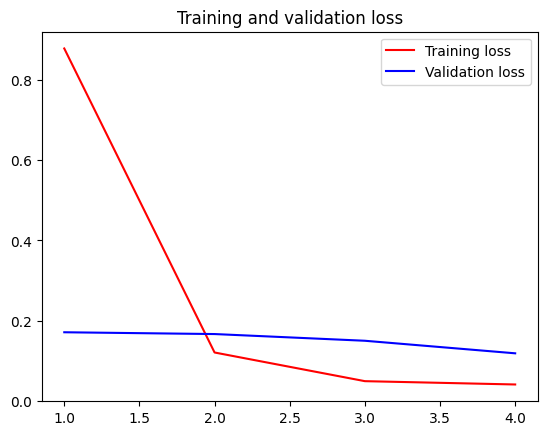

In [36]:
######-----Displaying curves of loss and accuracy during training-------######
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:
history.history

{'loss': [0.8774501085281372,
  0.12119154632091522,
  0.04987924546003342,
  0.04163621366024017],
 'accuracy': [0.6887994408607483,
  0.9718309640884399,
  0.9872568845748901,
  0.9885982275009155],
 'val_loss': [0.17152732610702515,
  0.16707244515419006,
  0.1503864824771881,
  0.11915935575962067],
 'val_accuracy': [0.9593495726585388,
  0.9566395878791809,
  0.9647696614265442,
  0.9756097793579102]}

comment
<!-- BECAUSE val_loss and val_accuracy were only after first Epoch
**BUT WHY?**

Epoch 1/4
10/10 [==============================] - ETA: 0s - loss: 2.0863 - accuracy: 0.2642WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.
10/10 [==============================] - 5s 385ms/step - loss: 2.0863 - accuracy: 0.2642 - val_loss: 1.9104 - val_accuracy: 0.3700

Epoch 2/4

10/10 [==============================] - 3s 342ms/step - loss: 1.5920 - accuracy: 0.5050

Epoch 3/4

10/10 [==============================] - 3s 290ms/step - loss: 0.6316 - accuracy: 0.7824

Epoch 4/4

10/10 [==============================] - 3s 305ms/step - loss: 0.5871 - accuracy: 0.8200 -->


# **Conclusion**

The next conditions make better results (**accuracy = 99%**) than previous:

- Only Top-7 letters, without other
- 7 in the last layer (Dense)
<!-- - Small numbers of filters (16) -->
- 'sparse_categorical_crossentropy' and Adam
<!-- - validation_steps = 40 (**WHY?**) -->

TOO GOOD?

# **6. Predicting for an external image**
# **!!! NEED TO UPLOAD THE NEW IMAGE**

REPLACE THE NEW IMAGE

In [53]:
# predict_img = cv2.imread("/content/georgian-letters-photo-database/georgian_letters_image_database/for_prediction/IMG_20230315_001116.jpg")

# predict_labels_df = pd.read_csv("/content/georgian-letters-photo-database/georgian_letters_image_database/for_prediction/IMG_20230219_144541.csv")
# predict_labels_df

In [54]:
# !mkdir cropped_images_for_prediction

In [55]:
# source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/for_prediction/'
# target_name = 'label_coordinates_pred'

# to_extract_coordinates(source_folder, target_name)
# df_pred = pd.read_csv(target_name + '.csv')


In [57]:
# # the folder where images locate
# source_folder_pred = 'georgian-letters-photo-database/georgian_letters_image_database/for_prediction/'

# # the folder where cropped images will be saved
# target_folder_pred = 'cropped_images_for_prediction/'

# to_crop_letters(df_pred, source_folder_pred, target_folder_pred, my_width, my_height)

1

In [45]:
# dictionary of Georgian alphabet

df = pd.read_csv('label_coordinates.csv')
letter_names = list(set(list(df['letter_name'])))

geo_dict = {}
for letter_name in letter_names:
    geo_dict[int(letter_name[:-1])] = letter_name[-1]

print(geo_dict)

{2: 'გ', 28: 'წ', 5: 'ვ', 20: 'ფ', 27: 'ძ', 8: 'ი', 21: 'ქ', 22: 'ღ', 4: 'ე', 32: 'ჰ', 18: 'ტ', 1: 'ბ', 26: 'ც', 10: 'ლ', 3: 'დ', 7: 'თ', 15: 'ჟ', 31: 'ჯ', 19: 'უ', 29: 'ჭ', 23: 'ყ', 17: 'ს', 0: 'ა', 11: 'მ', 12: 'ნ', 13: 'ო', 14: 'პ', 30: 'ხ', 25: 'ჩ', 9: 'კ', 6: 'ზ', 24: 'შ', 16: 'რ'}


based on: https://data-flair.training/blogs/handwritten-character-recognition-neural-network/

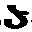

1/1 [==============================] - 0s 235ms/step
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
1/1 [==============================] - 0s 113ms/step
3
1/1 [==============================] - 0s 157ms/step
The letter on the image is დ


In [47]:
# example for 'ა'

img_url = '/content/cropped_images_predict/IMG_20230315_001116_ა_1.jpg'
# not ok
# img_url = '/content/cropped_images_predict/IMG_20230315_001116_ა_2.jpg'
# not ok
# img_url = '/content/cropped_images_predict/IMG_20230315_001116_ე_1.jpg'
# not ok
# img_url = '/content/cropped_images_predict/IMG_20230315_001116_ი_1.jpg'
# not ok
# img_url = '/content/cropped_images_predict/IMG_20230315_001116_ი_2.jpg'
# not ok
# img_url = '/content/cropped_images_predict/IMG_20230315_001116_ი_3.jpg'
# not ok
# img_url = '/content/cropped_images_predict/IMG_20230315_001116_ლ_1.jpg'
# not ok

pred_img = cv2.imread(img_url)
cv2_imshow(pred_img)

img_final = np.reshape(pred_img, (3, my_height, my_width, 1))
# print(img_final)
print(model.predict(img_final))
print(np.argmax(model.predict(img_final)))
print("The letter on the image is {0}".format(geo_dict[np.argmax(model.predict(img_final))]))


In [84]:
head_letter_dict.keys()

dict_keys(['ი', 'ა', 'ე', 'ს', 'რ', 'ო', 'ლ'])

In [41]:
import re

pred_folder = "cropped_images_predict/"

pred_dir_list = os.listdir(pred_folder)
# ა_list = [d for d in dir_list if "ა" in d]
pred_letter_list = [re.findall("\_(.)\_", d)[0] for d in pred_dir_list if re.findall("\_(.)\_", d)]

# if letter in head_letter_dict.keys()

for img_url in pred_dir_list:
    letter = re.findall("\_(.)\_", img_url)[0]
    if letter in head_letter_dict.keys():
        print()
        print()
        pred_img = cv2.imread(pred_folder+img_url)
        img_final = np.reshape(pred_img, (3, my_height, my_width, 1))
        # recognized_letter = geo_dict[np.argmax(model.predict(img_final))] # NO RELATED TO geo_dict !!!
        print(img_url, letter, np.argmax(model.predict(img_final)))
        print(model.predict(img_final))
        # if recognized_letter == letter:
        #     print("RECOGNIZED CORRECTLY:", letter)
        # else:
        #     print("RECOGNIZED INCORRECTLY: real - {}, recognized - {}".format(letter, recognized_letter))




1/1 [==============================] - 0s 68ms/step
IMG_20230315_001116_ა_1.jpg ა 3
1/1 [==============================] - 0s 44ms/step
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


1/1 [==============================] - 0s 65ms/step
IMG_20230315_001116_ლ_1.jpg ლ 10
1/1 [==============================] - 0s 38ms/step
[[0.80239594 0.         0.         0.1976041  0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.        ]]


1/1 [==============================] - 0s 57ms/step
IMG_20230315_001116_ი_1.jpg ი 0
1/1 [==============================] - 0s 85ms/step
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]]


1/1 [==============================] - 0s 43ms/step
IMG_20230315_001116_ს_1.jpg ს 7
1/1 [==============================] - 0s 128ms/step
[[8.7721054e-07 0.0000000e+00 0.0000000e+00 9.9999917e-01 0.0000000e+00
  0.0

1/1 [==============================] - 0s 31ms/step


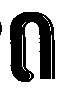

In [87]:
from google.colab.patches import cv2_imshow

img_final = np.reshape(pred_img, (3, my_height, my_width, 1))

img_pred = geo_dict[np.argmax(model.predict(img_final))]

# # cv2.putText(img, "Dataflair _ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(pred_img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
cv2_imshow(pred_img)


# **What to do next:**


  - **TO CHECK ALL THE LABELS ON ALL THE PHOTOS -- THERE ARE MISTAKES**
  <!-- - to view the cropped dataset and remove noisy images (totally black and so on) or maybe to change threshold for black/white masking -->
  - to top up the dataset
  - TO TRY **scipy.ndimage as ndi** and **smoothing** or sharping (DataCamp, biomedical, chapter 2, lesson 3)
  - to fix validation curves on graphics
  - **TO VISUALIZE A PREDICTION**

Downloading the cropped images:

In [ ]:
# Downloading the cropped images:

# !zip -r /content/cropped_images.zip /content/cropped_images

# from google.colab import files
# files.download("/content/cropped_images.zip")

In [ ]:
# !zip -r /content/grouped_images.zip /content/grouped_images

# from google.colab import files
# files.download("/content/grouped_images.zip")

# **===== DRAFTS =====**

In [ ]:
from google.colab.patches import cv2_imshow


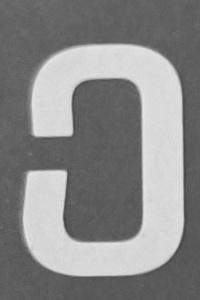

In [ ]:
img_test = cv2.imread("/content/cropped_images/IMG_20230212_163114_ე_1.jpg")

cv2_imshow(img_test)


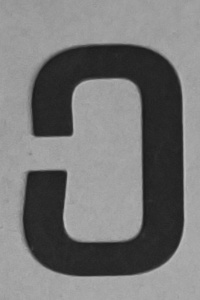

In [ ]:
cv2_imshow(invert_image(img_test))


In [ ]:
x = []
img = Image.open('grouped_images/train/ა/IMG_20220404_150259_ა_1.jpg')
img.load()
data = np.asarray(img, dtype="int32")
x.append(data)
x = np.array(x)
print(x.shape)

(1, 150, 100)


In [ ]:
# threshold
thresh = cv2.threshold(img_test, 180, 255, cv2.THRESH_BINARY)[1]

# count number of white pixels
mean = np.mean(img_test)
print("mean =", mean)

mean_masked = np.mean(img_test[np.where(thresh == 255)])
print("masked mean =", mean_masked)


mean = 136.24663333333334
masked mean = 215.07470801449858


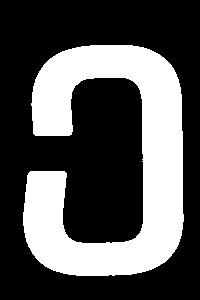

-1

In [ ]:
# write thresh to disk
cv2.imwrite("gray_with_spots_thresh.png", thresh)

# display it
cv2_imshow(thresh)
cv2.waitKey(0)

In [ ]:
# #creating two dir for training and testing
# !mkdir test_labels train_labels

# # lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# # Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
# !ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/

# # Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
# !ls annotations/* | xargs -I{} mv {} train_labels/

In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

In [ ]:
#creating two dir for training and testing
!mkdir test train

In [ ]:
# 86 * 0.2

17.2

In [ ]:
# Moves the first 51/86 labels (20% of the labels) to the testing dir: `test_labels`
!ls georgian-letters-photo-database/* | head -51 | xargs -I{} mv {} test/

# to cancel:
# !ls test/* | xargs -I{} mv {} georgian-letters-photo-database/

In [ ]:
!ls georgian-letters-photo-database/* | xargs -I{} mv {} train/